In [ ]:
from __future__ import print_function
from Bio.PDB import *
import os
import numpy as np
import pandas as pd
import collections
import csv
from scipy.spatial import distance
from pygsp import graphs, features
import networkx as nx
import matplotlib.pyplot as plt
import pickle

In [ ]:
amino_lookup = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
keys =  ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
compressibility_value = [25.5, -26.62, -30.9, -33.12, -32.82, -32.6, -36.17, -27, -31.84, -31.78, -31.78, -32.4, -31.18, -34.54, -23.25, -29.88, -31.23, -30.24, -35.01, -30.62]
thermodynamic_transfer_hydrophobicity_value = [0.87, 0.85, 0.09, 0.66, 1.52, 0, 0.67, 0.1, 0.87, 3.15, 2.17, 1.64, 1.67, 2.87, 2.77, 0.07, 0.07, 3.77, 2.67, 1.87]
surrounding_hydrophobicity_value = [13.05, 12.4, 11.72, 11.1, 14.3, 11.78, 11.41, 12.2, 12.42, 15.34, 14.19, 11.01, 13.62, 13.89, 11.06, 11.68, 12.12, 13.96, 13.57, 14.73]
Polarity_value = [0, 52, 3.38, 49.7, 1.48, 3.53, 49.9, 0, 51.6, 0.1, 0.13, 49.5, 1.43, 0.35, 1.58, 1.67, 1.66, 2.1, 1.61, 0.13]
isoelectric_point_value = [6, 10.76, 5.41, 2.77, 5.05, 5.65, 5.22, 5.97, 7.59, 6.02, 5.98, 9.74, 5.74, 5.48, 6.3, 5.68, 5.66, 5.89, 5.66, 5.96]
equilibrium_constant_value = [2.34, 1.81, 2.02, 2.01, 1.65, 2.17, 2.19, 2.34, 1.82, 1.36, 2.36, 2.18, 2.28, 1.89, 1.99, 2.21, 2.1, 2.38, 2.2, 2.32]
bulkiness_value = [11.5, 14.28, 12.82, 11.68, 13.46, 14.45, 13.57, 3.4, 13.67, 21.4, 21.4, 15.71, 16.25, 19.8, 17.43, 9.47, 15.77, 21.61, 18.03, 21.57]
chromatographic_index_value = [9.9, 4.6, 5.4, 2.8, 2.8, 9, 3.2, 5.6, 8.2, 17.1, 17.6, 3.5, 14.7, 18.8, 14.8, 6.9, 9.5, 17, 15, 14.3]
refractive_index_value = [14.34, 26.66, 13.28, 12, 35.77, 17.56, 17.26, 0, 21.81, 19.06, 18.78, 21.29, 21.64, 29.4, 10.93, 6.35, 11.01, 42.53, 31.55, 13.92]
normalized_consensus_hydrophobicity_value = [0.62, -2.53, -0.78, 0.9, 0.29, -0.85, -0.74, 0.48, -0.4, 1.38, 1.06, -1.5, 0.64, 1.19, 0.12, -0.18, -0.05, 0.81, 0.26, 1.08]
short_medium_nonbonded_energy_value = [1.4, 0.92, 1.18, 1.16, 1.37, 1.12, 1.16, 1.36, 1.22, 1.19, 1.32, 1.07, 1.3, 1.14, 1.24, 1.3, 1.25, 1.03, 1.03, 1.25]
long_nonbonded_energy_value = [0.49, 0.55, 0.38, 0.35, 0.67, 0.4, 0.37, 0.53, 0.54, 0.76, 0.65, 0.3, 0.65, 0.72, 0.46, 0.45, 0.52, 0.83, 0.65, 0.73]
total_nonbonded_energy_value = [1.9, 1.48, 1.56, 1.52, 2.04, 1.52, 1.54, 1.9, 1.76, 1.95, 1.97, 1.37, 1.96, 1.86, 1.7, 1.75, 1.77, 1.87, 1.69, 1.98]
αhelical_tendencies_value = [1.42, 0.98, 0.67, 1.01, 0.7, 1.11, 1.51, 0.57, 1, 1.08, 1.21, 1.16, 1.45, 1.13, 0.57, 0.77, 0.83, 1.08, 0.69, 1.06]
βstructure_tendencies_value = [0.83, 0.93, 0.89, 0.54, 1.19, 1.1, 0.37, 0.75, 0.87, 1.6, 1.3, 0.74, 1.05, 1.38, 0.55, 0.75, 1.19, 1.37, 1.47, 1.7]
turn_tendencies_value = [0.66, 0.95, 1.56, 1.46, 1.19, 0.98, 0.74, 1.56, 0.95, 0.47, 0.59, 1.01, 0.6, 0.6, 1.52, 1.43, 0.96, 0.96, 1.14, 0.5]
Coil_tendencies_value = [0.71, 1.07, 1.37, 1.21, 1.19, 0.87, 0.84, 1.52, 1.07, 0.66, 0.69, 0.99, 0.59, 0.71, 1.61, 1.34, 1.08, 0.76, 1.07, 0.63]
helical_contact_area_value = [20, 55, 28, 26, 25, 36, 33, 13, 37, 39, 35, 46, 43, 46, 22, 20, 28, 61, 46, 33]
mean_rms_fluctuational_displacement_value = [0.96, 1.05, 1.04, 1.14, 0.87, 1.07, 1.07, 1.16, 0.8, 0.76, 0.79, 1.14, 0.78, 0.69, 1.16, 1.13, 0.96, 0.77, 1.01, 0.79]
buriedness_value = [0.38, 0.07, 0.15, 0.14, 0.57, 0.11, 0.09, 0.38, 0.31, 0.56, 0.5, 0.04, 0.42, 0.51, 0.18, 0.23, 0.23, 0.4, 0.26, 0.48]
solvent_accessible_reduction_ratio_value = [3.7, 2.53, 2.12, 2.6, 3.03, 2.7, 3.3, 3.13, 3.57, 7.69, 5.88, 1.79, 5.21, 6.6, 2.12, 2.43, 2.6, 6.25, 3.03, 7.14]
average_number_of_surrounding_residues_value = [6.05, 5.7, 5.04, 4.95, 7.86, 5.45, 5.1, 6.16, 5.8, 7.51, 7.37, 4.88, 6.39, 6.62, 5.65, 5.53, 5.81, 6.98, 6.73, 7.62]
power_at_Nterminal_αhelix_value = [1.59, 0.67, 0.53, 0.53, 0.33, 0.98, 1.45, 0.53, 0.89, 1.22, 1.91, 1.13, 1.25, 1.14, 0, 0.7, 0.75, 1.33, 0.58, 1.42]
power_at_Cterminal_αhelix_value = [1.44, 0.39, 0.93, 2.13, 0.76, 1.2, 2.01, 0.62, 0.56, 0.68, 0.58, 0.59, 0.73, 1.01, 2.19, 0.81, 1.25, 1.4, 0.72, 0.63]
power_at_middle_αhelix_value = [1.22, 1.59, 0.93, 0.56, 1.53, 1.63, 1.28, 0.4, 2.23, 0.77, 1.05, 1.65, 1.47, 1.13, 0, 0.87, 0.46, 0.46, 0.52, 1.2]
partial_molar_volume_value = [60.46, 127.34, 78.01, 73.83, 67.7, 93.9, 85.88, 43.25, 98.79, 107.72, 107.75, 108.5, 105.35, 121.48, 82.83, 60.62, 76.83, 143.91, 123.6, 90.78]
average_medium_contacts_value = [2.11, 1.94, 1.84, 1.8, 1.88, 2.03, 2.09, 1.53, 1.98, 1.77, 2.19, 1.96, 2.27, 1.98, 1.32, 1.57, 1.57, 1.9, 1.67, 1.63]
average_long_contacts_value = [3.92, 3.78, 3.64, 2.85, 5.55, 3.06, 2.72, 4.31, 3.77, 5.58, 4.59, 2.79, 4.14, 4.53, 3.57, 3.75, 4.09, 4.83, 4.93, 5.43]
Hgm_combined_surrounding_hydrophobicity_value = [13.85, 13.1, 13.02, 11.61, 15.37, 12.61, 11.38, 13.34, 13.82, 15.28, 14.13, 11.58, 13.86, 13.93, 12.35, 13.39, 12.7, 15.48, 13.88, 14.56]
solvent_accessible_SA_denatured_value = [104, 210.2, 134.9, 132.2, 132.5, 164.9, 161.9, 73.4, 165.8, 171.5, 161.4, 195.2, 189.8, 182, 135.1, 111.4, 130.4, 208.8, 196.4, 143.9]
solvent_accessible_SA_native_value = [33.2, 94.5, 60.5, 62.4, 17.9, 71.5, 81, 29.2, 57.7, 28.3, 31.1, 107.5, 41.3, 33.1, 60.7, 48.7, 52, 39.5, 50.4, 28.1]
solvent_accessible_SA_unfolding_value = [70.9, 116, 74, 69.6, 114.3, 93.3, 80.5, 44, 107.9, 142.7, 129.8, 87.5, 147.9, 148.4, 73.5, 62.8, 78, 167.8, 145.9, 115.6]
Gibbs_free_hydration_energy_change_unfolding_value = [-0.54, -5.96, -3.55, -2.97, -1.64, -3.92, -3.71, -0.59, -3.38, 0.32, 0.27, -2.19, -0.6, -1.06, 0.32, -3.82, -1.97, -3.8, -5.64, 0.13]
Gibbs_free_hydration_energy_change_denatured_value = [-0.58, -12.78, -6.63, -6.1, -1.91, -7.12, 7.37, -0.82, -5.57, 0.4, 0.35, -5.97, -0.71, -1.35, 0.56, -6.18, -3.66, -4.71, -8.45, 0.18]
Gibbs_free_hydration_energy_change_native_protein_value = [-0.06, -6.85, -3.03, -3.11, -0.27, -3.15, -3.62, -0.23, -2.18, 0.07, 0.07, -1.7, -0.1, -0.28, 0.23, -2.36, -1.69, -0.88, -2.82, 0.04]
unfolding_hydration_enthalpy_change_value = [-2.24, -10.43, -5.68, -4.54, -3.43, -6.23, -5.63, -1.46, -6.83, -3.84, -3.52, -5.02, -4.16, -5.11, -1.95, -5.94, -4.39, -8.99, -10.67, -3.15]
unfolding_hydration_entropy_change_value = [1.7, 4.47, 2.13, 1.57, 1.79, 2.31, 1.92, 0.87, 3.45, 4.16, 3.79, 2.83, 3.56, 4.05, 2.27, 2.12, 2.42, 5.19, 5.03, 3.28]
unfolding_hydration_heat_capacity_change_value = [14.22, 16.66, 3.91, 2.73, 9.41, 3.74, 3.17, 4.88, 20.05, 41.98, 38.26, 17.68, 31.67, 39.06, 23.69, 6.14, 16.11, 37.69, 30.54, 32.58]
unfolding_Gibbs_free_energy_value = [0.51, 5.25, 3.26, 2.89, 2.71, 3.69, 3.58, 0.68, 3.95, -0.4, -0.35, 1.87, 1.13, 3.22, -0.39, 3.42, 1.74, 5.59, 6.56, -0.19]
volume_value = [1, 7, 4, 4, 2, 5, 5, 0, 6, 4, 4, 5, 4, 7, 3, 2, 3, 10, 8, 3]
shape_value = [0, 5, 2, 2, 0, 3, 3, 0, 2, 1, 2, 0, 0, 2, 0, 0, 1, 2, 2, 1]
flexibility_value = [0, 5, 2, 2, 1, 3, 3, 0, 2, 2, 2, 4, 3, 2, 0, 1, 1, 2, 2, 1]
unfolding_enthalpy_value = [2.77, 6.03, 3.64, 4.72, 8.64, 4.47, 5.69, 1.23, 7.64, 4.03, 3.69, 3.57, 7.06, 11.93, 1.97, 5.8, 4.42, 13.46, 14.41, 3.45]
unfolding_entropy_changes_of_chain_value = [-2.25, -0.78, -0.39, -1.83, -5.92, -0.78, -2.11, -0.55, -3.69, -4.42, -4.04, -1.7, -5.93, -8.71, -2.36, -2.38, -2.68, -7.87, -7.95, -3.64]
unfolding_Gibbs_free_energy_change_value = [-0.02, -0.71, -0.3, -0.08, 1.08, -0.23, -0.13, 0.09, 0.56, -0.08, -0.08, -0.32, 0.53, 2.16, -0.06, -0.4, -0.24, 1.78, 0.91, -0.06]
unfolding_enthalpy_change_value  = [0.51, -4.4, -2.03, 0.18, 5.21, -1.76, 0.05, -0.23, 0.79, 0.19, 0.17, -1.45, 2.89, 6.82, 0.02, -0.16, 0.04, 4.47, 3.73, 0.3]
unfolding_entropy_change_value = [-0.54, 3.69, 1.74, -0.26, -4.14, 1.53, -0.19, 0.31, -0.23, -0.27, -0.24, 1.13, -2.36, -4.66, -0.08, -0.24, -0.28, -2.69, -2.82, -0.36]
#pK′, equilibrium constant with reference to the ionization property of cooh


In [ ]:
compressibility = dict(zip(keys,compressibility_value))
thermodynamic_transfer_hydrophobicity= dict(zip(keys,thermodynamic_transfer_hydrophobicity_value))
surrounding_hydrophobicity= dict(zip(keys,surrounding_hydrophobicity_value))
Polarity= dict(zip(keys,Polarity_value))
isoelectric_point= dict(zip(keys,isoelectric_point_value))
equilibrium_constant= dict(zip(keys,equilibrium_constant_value))
bulkiness= dict(zip(keys,bulkiness_value))
chromatographic_index= dict(zip(keys,chromatographic_index_value))
refractive_index= dict(zip(keys,refractive_index_value))
normalized_consensus_hydrophobicity= dict(zip(keys,normalized_consensus_hydrophobicity_value))
short_medium_nonbonded_energy= dict(zip(keys,short_medium_nonbonded_energy_value))
long_nonbonded_energy= dict(zip(keys,long_nonbonded_energy_value))
total_nonbonded_energy= dict(zip(keys,total_nonbonded_energy_value))
αhelical_tendencies= dict(zip(keys,αhelical_tendencies_value))
βstructure_tendencies= dict(zip(keys,βstructure_tendencies_value))
turn_tendencies= dict(zip(keys,turn_tendencies_value))
Coil_tendencies= dict(zip(keys,Coil_tendencies_value))
helical_contact_area= dict(zip(keys,helical_contact_area_value))
mean_rms_fluctuational_displacement= dict(zip(keys,mean_rms_fluctuational_displacement_value))
buriedness= dict(zip(keys,buriedness_value))
solvent_accessible_reduction_ratio= dict(zip(keys,solvent_accessible_reduction_ratio_value))
average_number_of_surrounding_residues= dict(zip(keys,average_number_of_surrounding_residues_value))
power_at_Nterminal_αhelix= dict(zip(keys,power_at_Nterminal_αhelix_value))
power_at_Cterminal_αhelix= dict(zip(keys,power_at_Cterminal_αhelix_value))
power_at_middle_αhelix= dict(zip(keys,power_at_middle_αhelix_value))
partial_molar_volume= dict(zip(keys,partial_molar_volume_value))
average_medium_contacts= dict(zip(keys,average_medium_contacts_value))
average_long_contacts= dict(zip(keys,average_long_contacts_value))
Hgm_combined_surrounding_hydrophobicity= dict(zip(keys,Hgm_combined_surrounding_hydrophobicity_value))
solvent_accessible_SA_denatured= dict(zip(keys,solvent_accessible_SA_denatured_value))
solvent_accessible_SA_native= dict(zip(keys,solvent_accessible_SA_native_value))
solvent_accessible_SA_unfolding= dict(zip(keys,solvent_accessible_SA_unfolding_value))
Gibbs_free_hydration_energy_change_unfolding= dict(zip(keys,Gibbs_free_hydration_energy_change_unfolding_value))
Gibbs_free_hydration_energy_change_denatured= dict(zip(keys,Gibbs_free_hydration_energy_change_denatured_value))
Gibbs_free_hydration_energy_change_native= dict(zip(keys,Gibbs_free_hydration_energy_change_native_protein_value))
unfolding_hydration_enthalpy_change= dict(zip(keys,unfolding_hydration_enthalpy_change_value))
unfolding_hydration_entropy_change= dict(zip(keys,unfolding_hydration_entropy_change_value))
unfolding_hydration_heat_capacity_change= dict(zip(keys,unfolding_hydration_heat_capacity_change_value))
unfolding_Gibbs_free_energy_changes_of_chain= dict(zip(keys,unfolding_Gibbs_free_energy_value))
volume= dict(zip(keys,volume_value))
shape= dict(zip(keys,shape_value))
flexibility= dict(zip(keys,flexibility_value))
unfolding_enthalpy_changes_of_chain= dict(zip(keys,unfolding_enthalpy_value))
unfolding_entropy_changes_of_chain= dict(zip(keys,unfolding_entropy_changes_of_chain_value))
unfolding_Gibbs_free_energy_change= dict(zip(keys,unfolding_Gibbs_free_energy_change_value))
unfolding_enthalpy_change= dict(zip(keys,unfolding_enthalpy_change_value))
unfolding_entropy_change= dict(zip(keys,unfolding_entropy_change_value))
amino_molecular_mass =  {'A': 89.09404,'R':174.20274,'N':132.11904,'D':133.10384,'C':121.15404 ,
       'Q':146.14594,'E':147.13074,'G':75.06714,'H':155.15634,'I':131.17464,
       'L':131.17464,'K':146.18934,'M':149.20784,'F':165.19184,'P':115.13194,
       'S':105.09344,'T':119.12034,'W':204.22844,'Y':181.19124,'V':117.14784}

In [ ]:
s_2data=pd.read_csv('/home/arul/Reegina/Protein-GSP/data/2s.csv')


In [ ]:
mask = ~s_2data['PDB'].str.contains('\?')
s_2data = s_2data[mask]


In [ ]:
import pandas as pd

# Assuming you have loaded your data into a DataFrame named df

# Sort the DataFrame by the 'PDB' column
s_2data_sorted = s_2data.sort_values(by='PDB')

# Reset the index after sorting
s_2data_sorted.reset_index(drop=True, inplace=True)

# df_sorted now contains the DataFrame sorted by the 'PDB' column

In [ ]:
s_2data_sorted.head()

,Unnamed: 0,Protein short name,PDB,Class,ln(kf)
0,28,ACYP2 (Horse) [5],1APS,α+β,-1.6
1,2,TRF1 (Human) [2],1BA5,α,5.9
2,50,Sso7d [35],1C8C,β,7.0
3,55,CspB (Bacillus caldolyticus) [38],1C9O,β,7.2
4,56,CspB (Bacillus subtilis) [38],1CSP,β,6.5


In [ ]:
lnkfs = s_2data_sorted['ln(kf)']

In [ ]:
pdb_lnkf_dict = {}

# Iterate through the DataFrame and populate the dictionary
for index, row in s_2data_sorted.iterrows():
    pdb = row['PDB']
    lnkf = row['ln(kf)']
    pdb_lnkf_dict[pdb] = lnkf

# pdb_lnkf_dict now contains a mapping of 'PDB' to 'ln(kf)'

In [ ]:
pdb_lnkf_dict

{'1APS': -1.6,
 '1BA5': 5.9,
 '1C8C': 7.0,
 '1C9O': 7.2,
 '1CSP': 6.5,
 '1D6O': 1.6,
 '1E0G': 7.0,
 '1E0L': 10.1,
 '1E0M': 8.9,
 '1FEX': 8.2,
 '1G6P': 6.3,
 '1HCD': 1.3,
 '1HDN': 2.7,
 '1IDY': 8.7,
 '1IMQ': 7.33,
 '1IO2': -0.25,
 '1J5U': 6.9,
 '1JO8': 2.5,
 '1K0S': 7.4,
 '1K85': 1.4,
 '1K9Q': 8.4,
 '1LOP': 6.6,
 '1MJC': 5.3,
 '1N88': 2.0,
 '1O6X': 6.8,
 '1RG8': 1.3,
 '1RYK': 9.1,
 '1ST7': 8.5,
 '1W4E': 10.2,
 '1W4J': 12.3,
 '1WIT': 0.41,
 '1YYJ': 8.4,
 '2A3D': 12.2,
 '2GA5': 5.4,
 '2JMC': 3.3,
 '2L6R': 10.3,
 '2MYO': 4.8,
 '2QJL': 2.6,
 '2WQG': 8.5,
 '2WXC': 11.7,
 '3CI2': 5.8,
 '3O49': 1.7,
 '3O4D': 4.9}

In [ ]:
DF.head

NameError: name 'DF' is not defined

In [ ]:
np.shape(pdbinfo_dict['1BA5']['distance_matrix'])

(954, 954)

In [ ]:
signals_weighted_rig = [
    "compressibility",
    "thermodynamic_transfer_hydrophobicity",
    "surrounding_hydrophobicity",
    "Polarity",
    "isoelectric_point",
    "equilibrium_constant",
    "bulkiness",
    "chromatographic_index",
    "refractive_index",
    "normalized_consensus_hydrophobicity",
    "short_medium_nonbonded_energy",
    "long_nonbonded_energy",
    "total_nonbonded_energy",
    "power_at_Nterminal_αhelix",
    "power_at_Cterminal_αhelix",
    "power_at_middle_αhelix",
    "partial_molar_volume",
    "average_medium_contacts",
    "average_long_contacts",
    "Hgm_combined_surrounding_hydrophobicity",
    "solvent_accessible_SA_denatured",
    "solvent_accessible_SA_native",
    "solvent_accessible_SA_unfolding",
    "Gibbs_free_hydration_energy_change_unfolding",
    "Gibbs_free_hydration_energy_change_denatured",
    "Gibbs_free_hydration_energy_change_native",
    "unfolding_hydration_enthalpy_change",
    "unfolding_hydration_entropy_change",
    "unfolding_hydration_heat_capacity_change",
    "unfolding_Gibbs_free_energy_changes_of_chain",
    "volume",
    "shape",
    "flexibility",
    "unfolding_enthalpy_changes_of_chain",
    "unfolding_entropy_changes_of_chain",
    "unfolding_Gibbs_free_energy_change",
    "unfolding_enthalpy_change",
    "unfolding_entropy_change",
    "amino_molecular_mass", "node_weighted_degree"
]

In [ ]:
rig_bool_signals = ["αhelical_tendencies",
    "βstructure_tendencies",
    "turn_tendencies",
    "Coil_tendencies",
    "helical_contact_area",
    "mean_rms_fluctuational_displacement",
    "buriedness",
    "solvent_accessible_reduction_ratio",
    "average_number_of_surrounding_residues", "node_degree", "aaalpha_helix", "residue_count"]

In [ ]:
weighted_lin_signals = ['avg_adj_degree', 'clustering_coeff']

In [ ]:
reader = csv.DictReader(open('../data/protein_data.csv', 'r'))
lnkf_values = dict()
for line in reader:
    lnkf_values[line['PDB ID']] = line['Ln (K_f)']

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [compressibility[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.5073294989580822, 0.5
6.1, 0.619521351305746, 0.6900000000000001
6.199999999999999, 0.5665277191920175, 0.6900000000000001
6.299999999999999, 0.5886572509382021, 0.6900000000000001
6.399999999999999, 0.5465729807132456, 0.7100000000000001
6.499999999999998, 0.540443375931539, 0.66
6.599999999999998, 0.5397833055749721, 0.6900000000000001
6.6999999999999975, 0.4959903839886503, 0.27
6.799999999999997, 0.4415071018417181, 0.44
6.899999999999997, 0.4330410406860855, 0.45
6.9999999999999964, 0.4252098485550581, 0.42000000000000004
7.099999999999996, 0.4267798196330197, 0.22
7.199999999999996, 0.44976519507829144, 0.22
7.299999999999995, 0.49436880047026127, 0.4
7.399999999999995, 0.47347471847356465, 0.36000000000000004
7.499999999999995, 0.4517913543856118, 0.17
7.599999999999994, 0.4872569994864675, 0.44
7.699999999999994, 0.4374756551234484, 0.44
7.799999999999994, 0.4420488587989058, 0.45
7.899999999999993, 0.4626312327448866, 0.45


In [2]:
import os
import numpy as np
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from pygsp import graphs

# Load your predefined data (assuming 'compressibility' and 'lnkf_values' are defined elsewhere)
# compressibility = ...
# lnkf_values = ...

# Temporary Code to finalize distance cutoff
distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print(distance_cutoff, end=', ')
    folders = [folder for folder in os.listdir('C:/Users/tyagi/Downloads/remains/PDBS/') if os.path.isdir(os.path.join('C:/Users/tyagi/Downloads/remains/PDBS/', folder))]
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
        file_path = os.path.join('C:/Users/tyagi/Downloads/remains/PDBS/', folder, 'distance_matrix.csv')
        if not os.path.isfile(file_path):
            continue  # Skip non-directory files
        n = np.asmatrix(np.loadtxt(file_path, delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i, j] > 0: n[i, j] = abs(j - i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01, 1, 0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [amino_hydrophobicity[s] for s in sequence]
#         signal = range(1, len(sequence)+1) -- MEaningless - Discuss
#         residue_counts = collections.Counter(sequence)
#         signal = [residue_counts[s] for s in sequence]
          NX = NX_dict[folder]
#         signal = nx.clustering(NX).values()
          signal = np.array(signal)
          signal_hat = G.gft(signal)
          lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax * lfc_cutoff])) / np.sum(abs(signal_hat))
          lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0, 1]
    print(np.max(points), end=', ')
    print(lfc_cutoffs[np.argmax(points)])

plt.scatter(lfc_cutoffs, points)
plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 47)

0.6654849758495952
0.19


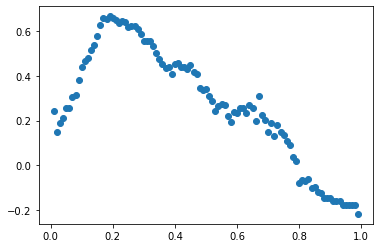

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [thermodynamic_transfer_hydrophobicity[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [surrounding_hydrophobicity[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.43375643026446015, 0.29000000000000004
6.1, 0.5254111500965313, 0.2
6.199999999999999, 0.5345097389328725, 0.24000000000000002
6.299999999999999, 0.5260801017479887, 0.23
6.399999999999999, 0.6291884250225661, 0.22
6.499999999999998, 0.5931679634917102, 0.26
6.599999999999998, 0.6359393676968891, 0.22
6.6999999999999975, 0.6152484992300709, 0.18000000000000002
6.799999999999997, 0.6250851086805537, 0.22
6.899999999999997, 0.6369486324909714, 0.26
6.9999999999999964, 0.5999253859192671, 0.24000000000000002
7.099999999999996, 0.6433825846772516, 0.19
7.199999999999996, 0.6709744792639651, 0.21000000000000002
7.299999999999995, 0.6831082735310234, 0.24000000000000002
7.399999999999995, 0.6432245063167312, 0.28
7.499999999999995, 0.6375587612173836, 0.17
7.599999999999994, 0.6209579833269318, 0.17
7.699999999999994, 0.6461508305257038, 0.18000000000000002
7.799999999999994, 0.6610723989888996, 0.19
7.899999999999993, 0.674850498210807, 0.19


0.674850498210807
0.19


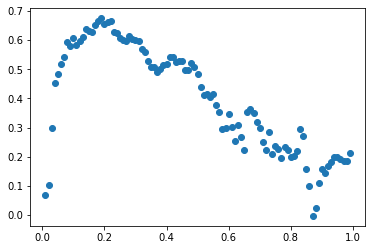

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [surrounding_hydrophobicity[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [bulkiness[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.5297522589081003, 0.29000000000000004
6.1, 0.5820026979896281, 0.32
6.199999999999999, 0.5816062274387565, 0.25
6.299999999999999, 0.5853311028279374, 0.28
6.399999999999999, 0.6793140894788668, 0.22
6.499999999999998, 0.6510650480428285, 0.22
6.599999999999998, 0.6843534372688834, 0.22
6.6999999999999975, 0.6563554024284032, 0.18000000000000002
6.799999999999997, 0.6459729133328524, 0.22
6.899999999999997, 0.6805727628995517, 0.23
6.9999999999999964, 0.6643019326118997, 0.19
7.099999999999996, 0.6856915469174094, 0.19
7.199999999999996, 0.7269215092252767, 0.22
7.299999999999995, 0.7218396028286834, 0.19
7.399999999999995, 0.6949927222165015, 0.19
7.499999999999995, 0.7105908204145851, 0.17
7.599999999999994, 0.6808977751141195, 0.17
7.699999999999994, 0.6793080137022116, 0.18000000000000002
7.799999999999994, 0.6645170150593598, 0.19
7.899999999999993, 0.6700150483063968, 0.19


0.6700150483063968
0.19


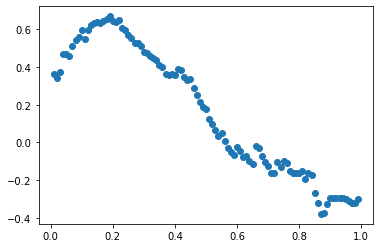

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [bulkiness[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [refractive_index[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.5745373601256439, 0.48000000000000004
6.1, 0.5260097135366201, 0.22
6.199999999999999, 0.5135956676641089, 0.25
6.299999999999999, 0.5097651774200407, 0.23
6.399999999999999, 0.6276546654739867, 0.22
6.499999999999998, 0.6176732805010293, 0.18000000000000002
6.599999999999998, 0.650411419601619, 0.2
6.6999999999999975, 0.6432948006821926, 0.2
6.799999999999997, 0.6540005369291542, 0.21000000000000002
6.899999999999997, 0.6783646207753479, 0.21000000000000002
6.9999999999999964, 0.6883179249068585, 0.19
7.099999999999996, 0.7112236746380092, 0.2
7.199999999999996, 0.7230745364526523, 0.21000000000000002
7.299999999999995, 0.7281097338322414, 0.2
7.399999999999995, 0.7391379559964357, 0.19
7.499999999999995, 0.7389884366990994, 0.19
7.599999999999994, 0.7390741593199383, 0.22
7.699999999999994, 0.7187892975856962, 0.18000000000000002
7.799999999999994, 0.7012951235840237, 0.19
7.899999999999993, 0.7087844318484227, 0.19


0.7087844318484227
0.19


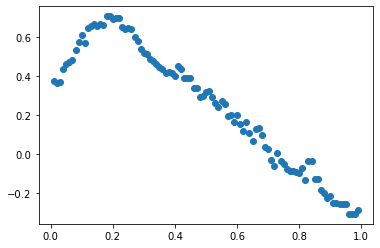

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [refractive_index[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [partial_molar_volume[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.5983969902410553, 0.48000000000000004
6.1, 0.5840734152284707, 0.32
6.199999999999999, 0.5775528500105244, 0.31
6.299999999999999, 0.5589889045844257, 0.24000000000000002
6.399999999999999, 0.6692284053507563, 0.21000000000000002
6.499999999999998, 0.6473955499303146, 0.19
6.599999999999998, 0.6858589820164191, 0.2
6.6999999999999975, 0.6698170784789678, 0.21000000000000002
6.799999999999997, 0.6571811967409579, 0.21000000000000002
6.899999999999997, 0.6702587189015398, 0.21000000000000002
6.9999999999999964, 0.6809730577083403, 0.19
7.099999999999996, 0.7018417476076568, 0.19
7.199999999999996, 0.7307701629681123, 0.21000000000000002
7.299999999999995, 0.7421465364135689, 0.19
7.399999999999995, 0.7331961367651304, 0.19
7.499999999999995, 0.7279306004576643, 0.19
7.599999999999994, 0.7367811635536734, 0.17
7.699999999999994, 0.6821316570336774, 0.18000000000000002
7.799999999999994, 0.671797373451458, 0.2
7.899999999999993, 0.6830046170035383, 0.22


0.6830046170035383
0.22


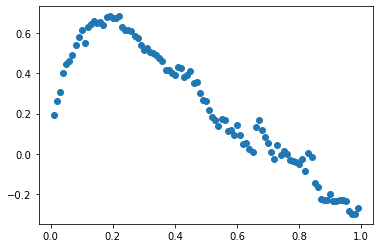

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [partial_molar_volume[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [average_medium_contacts[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.5708094947613855, 0.29000000000000004
6.1, 0.6298020845173095, 0.26
6.199999999999999, 0.6120553863629871, 0.28
6.299999999999999, 0.6204822691945499, 0.28
6.399999999999999, 0.7187168488168478, 0.22
6.499999999999998, 0.7191680228307592, 0.18000000000000002
6.599999999999998, 0.7335224766266372, 0.2
6.6999999999999975, 0.7168449133443349, 0.18000000000000002
6.799999999999997, 0.7265432874211655, 0.18000000000000002
6.899999999999997, 0.7024446434288376, 0.19
6.9999999999999964, 0.6783623442164289, 0.17
7.099999999999996, 0.7032000058900052, 0.19
7.199999999999996, 0.6986865987514066, 0.19
7.299999999999995, 0.70208311345821, 0.26
7.399999999999995, 0.7006551148632391, 0.19
7.499999999999995, 0.7160558757624774, 0.17
7.599999999999994, 0.7001788007103965, 0.17
7.699999999999994, 0.6966657076761962, 0.09999999999999999
7.799999999999994, 0.6993645344332706, 0.11
7.899999999999993, 0.6734847390448012, 0.11


0.6734847390448012
0.11


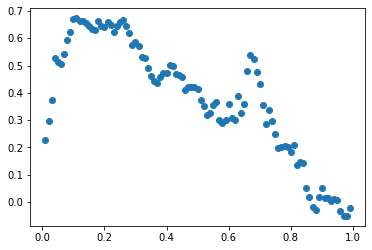

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [average_medium_contacts[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [Hgm_combined_surrounding_hydrophobicity[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.4479077792013894, 0.12
6.1, 0.5101345020472958, 0.12
6.199999999999999, 0.49314969310148704, 0.13
6.299999999999999, 0.48525010342415553, 0.14
6.399999999999999, 0.5691053136946914, 0.22
6.499999999999998, 0.5738166460948897, 0.26
6.599999999999998, 0.6096458249381209, 0.26
6.6999999999999975, 0.5882072677044662, 0.26
6.799999999999997, 0.5914191752921231, 0.22
6.899999999999997, 0.5887025749859696, 0.23
6.9999999999999964, 0.5727710659998484, 0.22
7.099999999999996, 0.6229290715287373, 0.19
7.199999999999996, 0.6473309795954565, 0.21000000000000002
7.299999999999995, 0.6561456984999846, 0.24000000000000002
7.399999999999995, 0.6225430162450116, 0.17
7.499999999999995, 0.6327166024016774, 0.17
7.599999999999994, 0.6231601017381887, 0.17
7.699999999999994, 0.6411675372183901, 0.16
7.799999999999994, 0.6497680538233842, 0.19
7.899999999999993, 0.6622293497165466, 0.19


0.6622293497165466
0.19


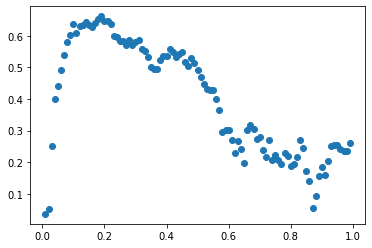

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [Hgm_combined_surrounding_hydrophobicity[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [solvent_accessible_SA_denatured[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.6076130925652298, 0.46
6.1, 0.5876058987690685, 0.22
6.199999999999999, 0.5901388342988843, 0.31
6.299999999999999, 0.561047776613378, 0.24000000000000002
6.399999999999999, 0.6598726967360524, 0.21000000000000002
6.499999999999998, 0.6646465549535381, 0.19
6.599999999999998, 0.6722779942060826, 0.2
6.6999999999999975, 0.674200490119532, 0.21000000000000002
6.799999999999997, 0.6747971378274796, 0.21000000000000002
6.899999999999997, 0.6986813582349997, 0.21000000000000002
6.9999999999999964, 0.6964990950815717, 0.22
7.099999999999996, 0.6951406185529838, 0.22
7.199999999999996, 0.7316184510640125, 0.21000000000000002
7.299999999999995, 0.7234103781842981, 0.19
7.399999999999995, 0.7134620467715187, 0.19
7.499999999999995, 0.7132831304308356, 0.17
7.599999999999994, 0.7348305192161103, 0.17
7.699999999999994, 0.6832008648513302, 0.18000000000000002
7.799999999999994, 0.6694750699793187, 0.22
7.899999999999993, 0.666837617794735, 0.22


0.666837617794735
0.22


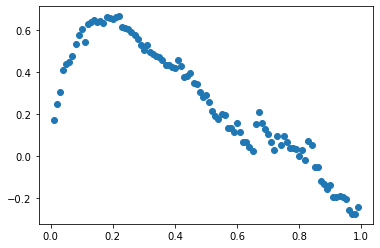

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [solvent_accessible_SA_denatured[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [solvent_accessible_SA_unfolding[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.53411953951699, 0.29000000000000004
6.1, 0.5559063625425873, 0.23
6.199999999999999, 0.5668982112480419, 0.25
6.299999999999999, 0.5538431654208984, 0.28
6.399999999999999, 0.6486392647250486, 0.22
6.499999999999998, 0.6345694282983226, 0.22
6.599999999999998, 0.6668067956529026, 0.2
6.6999999999999975, 0.6466327336183548, 0.18000000000000002
6.799999999999997, 0.6310010494418659, 0.22
6.899999999999997, 0.6538632225108184, 0.23
6.9999999999999964, 0.6643634679723659, 0.19
7.099999999999996, 0.7103100116894517, 0.19
7.199999999999996, 0.7326362508063231, 0.2
7.299999999999995, 0.72254692512303, 0.2
7.399999999999995, 0.7091308758006468, 0.19
7.499999999999995, 0.7274692783857739, 0.19
7.599999999999994, 0.6943760786312535, 0.17
7.699999999999994, 0.6901531854920515, 0.18000000000000002
7.799999999999994, 0.6795848861625495, 0.19
7.899999999999993, 0.6871932304046418, 0.19


0.6871932304046418
0.19


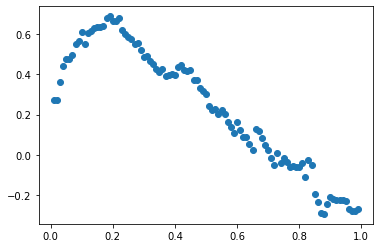

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [solvent_accessible_SA_unfolding[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [unfolding_hydration_enthalpy_change[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.6280764625735492, 0.39
6.1, 0.6675961575227425, 0.46
6.199999999999999, 0.6300334629476838, 0.38
6.299999999999999, 0.5936632068759566, 0.4
6.399999999999999, 0.6740377982943465, 0.22
6.499999999999998, 0.6524155137760577, 0.19
6.599999999999998, 0.7084320631868487, 0.43
6.6999999999999975, 0.6620276218178284, 0.42000000000000004
6.799999999999997, 0.6702864878453241, 0.42000000000000004
6.899999999999997, 0.6632408336646892, 0.45
6.9999999999999964, 0.6329418460981935, 0.42000000000000004
7.099999999999996, 0.6508311865796034, 0.19
7.199999999999996, 0.6765080576116024, 0.21000000000000002
7.299999999999995, 0.6585836214455157, 0.19
7.399999999999995, 0.6831277744969546, 0.21000000000000002
7.499999999999995, 0.6704192875490778, 0.19
7.599999999999994, 0.688304689963953, 0.22
7.699999999999994, 0.6968751452062184, 0.18000000000000002
7.799999999999994, 0.6701723613824142, 0.19
7.899999999999993, 0.6796201278421582, 0.18000000000000002


0.6796201278421582
0.18000000000000002


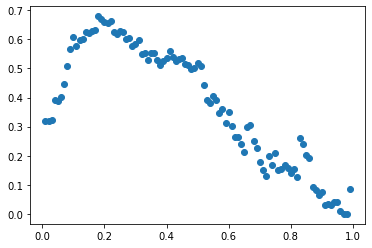

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [unfolding_hydration_enthalpy_change[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [unfolding_hydration_entropy_change[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.5597755173722725, 0.29000000000000004
6.1, 0.5873912760358069, 0.32
6.199999999999999, 0.57096147012451, 0.25
6.299999999999999, 0.5591148870150924, 0.28
6.399999999999999, 0.6537722167791329, 0.21000000000000002
6.499999999999998, 0.6247442622747242, 0.28
6.599999999999998, 0.663294113495524, 0.2
6.6999999999999975, 0.6351876695688249, 0.26
6.799999999999997, 0.6286507058148469, 0.22
6.899999999999997, 0.6502792674520907, 0.23
6.9999999999999964, 0.6498974321913297, 0.19
7.099999999999996, 0.6962166298760315, 0.19
7.199999999999996, 0.7341428653773188, 0.19
7.299999999999995, 0.7301619114133955, 0.2
7.399999999999995, 0.7077933515059702, 0.19
7.499999999999995, 0.7312296844093654, 0.2
7.599999999999994, 0.698427827415879, 0.17
7.699999999999994, 0.6893561360297015, 0.18000000000000002
7.799999999999994, 0.6600381224514652, 0.19
7.899999999999993, 0.7007797565916373, 0.19


0.7007797565916373
0.19


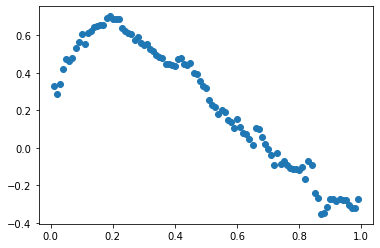

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [unfolding_hydration_entropy_change[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [unfolding_hydration_heat_capacity_change[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.4539163352219798, 0.29000000000000004
6.1, 0.49136425505147374, 0.27
6.199999999999999, 0.50454197285819, 0.29000000000000004
6.299999999999999, 0.49275480337905825, 0.28
6.399999999999999, 0.5809166643643305, 0.22
6.499999999999998, 0.5880158567484929, 0.26
6.599999999999998, 0.611692353099943, 0.22
6.6999999999999975, 0.6153529913863346, 0.18000000000000002
6.799999999999997, 0.5945946557627045, 0.22
6.899999999999997, 0.6225045061529352, 0.26
6.9999999999999964, 0.5772162724517933, 0.24000000000000002
7.099999999999996, 0.6200605755927106, 0.19
7.199999999999996, 0.6707221384370995, 0.22
7.299999999999995, 0.6547334735629606, 0.19
7.399999999999995, 0.6538579208143136, 0.19
7.499999999999995, 0.6714204227310909, 0.17
7.599999999999994, 0.6183605695614303, 0.17
7.699999999999994, 0.6519461946101306, 0.18000000000000002
7.799999999999994, 0.6333804699073317, 0.19
7.899999999999993, 0.6621256930576264, 0.19


0.6621256930576264
0.19


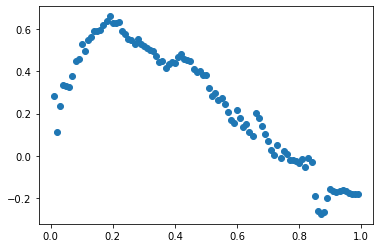

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [unfolding_hydration_heat_capacity_change[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [unfolding_Gibbs_free_energy_changes_of_chain[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.5885425055373938, 0.4
6.1, 0.6094363100524225, 0.19
6.199999999999999, 0.5932520106192551, 0.19
6.299999999999999, 0.5483514217549752, 0.23
6.399999999999999, 0.656836608191271, 0.22
6.499999999999998, 0.6243249417059894, 0.18000000000000002
6.599999999999998, 0.667952430034759, 0.33
6.6999999999999975, 0.681748034225121, 0.42000000000000004
6.799999999999997, 0.7084725982674811, 0.42000000000000004
6.899999999999997, 0.6924768805627504, 0.45
6.9999999999999964, 0.6578138354036249, 0.43
7.099999999999996, 0.6579232688721334, 0.28
7.199999999999996, 0.7026107902935483, 0.21000000000000002
7.299999999999995, 0.6883053571084294, 0.19
7.399999999999995, 0.6796597604035108, 0.2
7.499999999999995, 0.6785232637439532, 0.19
7.599999999999994, 0.6879294721389726, 0.22
7.699999999999994, 0.6837616141291504, 0.23
7.799999999999994, 0.6571761875249943, 0.22
7.899999999999993, 0.6741515766056877, 0.22


0.6741515766056877
0.22


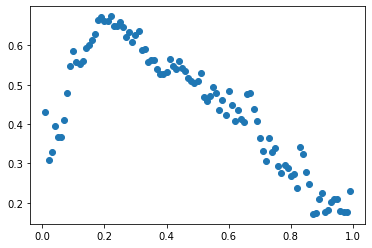

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [unfolding_Gibbs_free_energy_changes_of_chain[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [unfolding_enthalpy_changes_of_chain[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.514276384586883, 0.37
6.1, 0.5548183996335552, 0.19
6.199999999999999, 0.5941233440555095, 0.19
6.299999999999999, 0.587358977527502, 0.23
6.399999999999999, 0.6319830375203833, 0.21000000000000002
6.499999999999998, 0.590037500843943, 0.21000000000000002
6.599999999999998, 0.6201688714778073, 0.2
6.6999999999999975, 0.6469658800664132, 0.2
6.799999999999997, 0.6742145061945727, 0.2
6.899999999999997, 0.673105989761172, 0.19
6.9999999999999964, 0.6731543724660191, 0.19
7.099999999999996, 0.7036254658852211, 0.19
7.199999999999996, 0.7320391000074233, 0.19
7.299999999999995, 0.748647780623106, 0.2
7.399999999999995, 0.7354696397565561, 0.21000000000000002
7.499999999999995, 0.7467303899670668, 0.22
7.599999999999994, 0.7370419498931644, 0.22
7.699999999999994, 0.707346861556096, 0.21000000000000002
7.799999999999994, 0.6937890861898979, 0.19
7.899999999999993, 0.6994605333758952, 0.18000000000000002


0.6994605333758952
0.18000000000000002


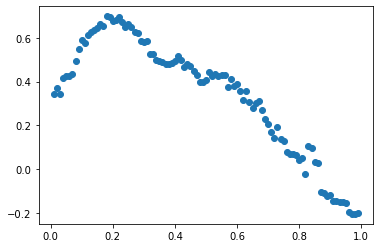

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [unfolding_enthalpy_changes_of_chain[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [amino_molecular_mass[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.6361930668834941, 0.46
6.1, 0.5927385442877667, 0.22
6.199999999999999, 0.573691419264684, 0.31
6.299999999999999, 0.6090222509405616, 0.24000000000000002
6.399999999999999, 0.6994049996821662, 0.22
6.499999999999998, 0.6786973981471272, 0.19
6.599999999999998, 0.7125524932441694, 0.2
6.6999999999999975, 0.6847004094208784, 0.21000000000000002
6.799999999999997, 0.6866230896144534, 0.21000000000000002
6.899999999999997, 0.6949522932820646, 0.21000000000000002
6.9999999999999964, 0.684971578269466, 0.19
7.099999999999996, 0.6967792961308216, 0.2
7.199999999999996, 0.7406609481693416, 0.21000000000000002
7.299999999999995, 0.7329974536361277, 0.2
7.399999999999995, 0.7323846317462335, 0.19
7.499999999999995, 0.7211422336650697, 0.19
7.599999999999994, 0.7088720239874196, 0.17
7.699999999999994, 0.6829257295955213, 0.22
7.799999999999994, 0.6772477784307723, 0.22
7.899999999999993, 0.673769763213463, 0.22


0.673769763213463
0.22


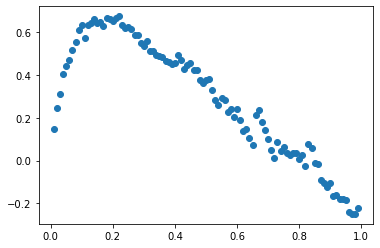

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [amino_molecular_mass[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
## Temporary Code to finalize distance cutoff

distance_cutoffs = np.arange(6, 8, 0.1)

for distance_cutoff in distance_cutoffs:
    print (distance_cutoff, end=', ')
    folders = os.listdir('../data/regression_model/new_pdb/')
    G_dict = dict()
    NX_dict = dict()
    for index, folder in enumerate(folders):
#         print (folder, end=', ')
        n = np.asmatrix(np.loadtxt('../data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
        n[n >= distance_cutoff] = 0
        # taking |j-i| as weights
        for i in range(np.shape(n)[0]):
            for j in range(np.shape(n)[1]):
                if n[i,j] > 0: n[i,j] = abs(j-i)
        G = graphs.Graph(n)
        G.compute_fourier_basis()
        G_dict[folder] = G
        NX_dict[folder] = nx.Graph(n)

    lfc_cutoffs = np.arange(0.01,1,0.01)
    points = np.zeros_like(lfc_cutoffs)
    for p, lfc_cutoff in enumerate(lfc_cutoffs):
        lfc = np.zeros(len(folders))
        lnkf = np.zeros(len(folders))
        for index, folder in enumerate(folders):
            G = G_dict[folder]
            sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
            signal = [volume[s] for s in sequence]
            signal = np.array(signal)
            signal_hat = G.gft(signal)
            lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
            lnkf[index] = lnkf_values[folder.upper()]
        points[p] = np.corrcoef(lfc, lnkf)[0,1]
    print (np.max(points), end=', ')
    print (lfc_cutoffs[np.argmax(points)])

6.0, 0.6257850992588553, 0.46
6.1, 0.5795550629517027, 0.22
6.199999999999999, 0.5598561048644619, 0.19
6.299999999999999, 0.5972591706624185, 0.24000000000000002
6.399999999999999, 0.6856430869898864, 0.22
6.499999999999998, 0.6572702670882759, 0.19
6.599999999999998, 0.7022372178145737, 0.2
6.6999999999999975, 0.6722349453556561, 0.2
6.799999999999997, 0.6738167597750496, 0.21000000000000002
6.899999999999997, 0.6802460193264931, 0.21000000000000002
6.9999999999999964, 0.6773353230002221, 0.19
7.099999999999996, 0.6890050471539559, 0.2
7.199999999999996, 0.7340267114491296, 0.21000000000000002
7.299999999999995, 0.7330016003397307, 0.2
7.399999999999995, 0.7305835137855341, 0.2
7.499999999999995, 0.7234311993752666, 0.19
7.599999999999994, 0.7149601213857001, 0.22
7.699999999999994, 0.6818351670892979, 0.22
7.799999999999994, 0.6760074180272226, 0.22
7.899999999999993, 0.6788825836306719, 0.22


0.6788825836306719
0.22


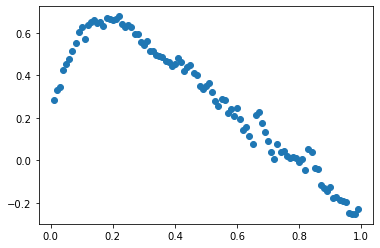

In [ ]:
lfc_cutoffs = np.arange(0.01,1,0.01)
points = np.zeros_like(lfc_cutoffs)


for p, lfc_cutoff in enumerate(lfc_cutoffs):

    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        G = G_dict[folder]
        sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
        signal = [volume[s] for s in sequence]
#         signal = [amino_molecular_mass[s] for s in sequence]
#         signal = G.d
#         signal = list(nx.degree_centrality(NX_dict[folder]).values())
#         signal = list(nx.betweenness_centrality(NX_dict[folder]).values())
#         signal = list(nx.algorithms.link_analysis.pagerank(NX_dict[folder]).values())
        signal = np.array(signal)
        signal_hat = G.gft(signal)
        lfc[index] = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        lnkf[index] = lnkf_values[folder.upper()]

    points[p] = np.corrcoef(lfc, lnkf)[0,1]

plt.scatter(lfc_cutoffs, points)
print (np.max(points))
print (lfc_cutoffs[np.argmax(points)])
plt.show()

In [ ]:
lfc_cutoff = 0.26

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.8952020665375362
0.8630771148815856
0.8334425898685317
0.8437402821508596
0.9324189672494848
0.9316632721687619
0.8641851134570273
0.8207481363915216
0.8128251838646388
0.9303963954171102
0.907524467566465
0.839666870377501
0.9395526560616606
0.8028815061921616
0.8607595261196815
0.8975325791761407
0.9238183819043019
0.9035036211891365
0.8560557000882674
0.9410990946487744
0.8509832518481246
0.9261586222514882
0.8072529281240017
0.812568916046559
0.8968468793507551
0.8447632061783438
0.8365893418393229
0.9274480341268281
0.8940224898068659
0.8182860515929042
0.9223055682169428
0.9294437482234499
0.9098032961468409
0.7957871340457691
0.9217187429920678
0.895185922496787
0.8562420042223746
0.9146698989579615
0.8420007162229706
0.8817149200615819
0.8704177796703375
0.780101845573884
0.7579282902174292
0.8705479279631257
0.8784529625096719
0.8364870156627714
0.8597181160486137
0.9612784981950023
0.8841158913278445
0.9266169168128013
0.8293523175540618
0.9392064774733899


In [ ]:
lfc_cutoff = 0.22

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [volume[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.7895142191556674
0.6675438396465918
0.6836321632099621
0.6761363813358562
0.8365854432236822
0.8344712572093409
0.6511263306867264
0.5796808397619151
0.645663261341131
0.8862166173441208
0.6998126415542977
0.7111005554230192
0.82343170801363
0.6152016802388124
0.7107792385004212
0.7186278334382136
0.8246975836331507
0.7886638833252931
0.685812237393498
0.838547916600939
0.6486985471559181
0.7805406897362219
0.62104686222361
0.6509487635689639
0.8191149165005763
0.6343394964994952
0.628040439180943
0.7389972670766941
0.7263491219144826
0.5513882164449153
0.8617448040037086
0.867077177194145
0.7304973542271377
0.5683072800545064
0.8147648388034333
0.8219085106516428
0.6437469874159323
0.6604156628646332
0.648869960495175
0.6955198247202161
0.673642255387911
0.5817868895614086
0.5970024966601899
0.7192927083377235
0.7178909550879728
0.665110872660466
0.68363389027074
0.9148506822153815
0.7096557138394951
0.7558328644676843
0.6413960946816621
0.8743687506429577


In [ ]:
lfc_cutoff = 0.22

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [amino_molecular_mass[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.8292856695949697
0.7495922890649247
0.7652484523956595
0.7612237000301739
0.8636844046786027
0.8907585741713243
0.7479047904401999
0.6763706770867691
0.7365075661153443
0.9106352853892846
0.7738496226960853
0.7817964613856778
0.8759283636940123
0.7047916282508985
0.7866371112167656
0.7940596669683267
0.8589721086209136
0.8453113806604754
0.7567076953668624
0.8782193046447089
0.7445882329282941
0.8138662018412791
0.7142947187423063
0.718850877928574
0.8752963600330853
0.7282265210529169
0.7147680924295787
0.8075673416325273
0.8027069517044538
0.6644209843170542
0.8908875392478683
0.8981413052575857
0.7936316110579996
0.6743187931848823
0.8380737626319088
0.8623062332650596
0.7215639379507468
0.736219678972498
0.7408539790419757
0.7722141421623212
0.7440021772340092
0.700817605700873
0.6885168991207666
0.7925826801852086
0.7791950309230394
0.7478925249090524
0.7410774638087526
0.9253111305970366
0.771876228538491
0.823052507842412
0.7307547407633191
0.9055749528124307


In [ ]:
lfc_cutoff = 0.18

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [unfolding_enthalpy_changes_of_chain[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.8096400392456393
0.5279000943004709
0.5515577603317324
0.6964319348444495
0.8254613542337882
0.7463728438078021
0.6512170015633975
0.5306381780281703
0.5551415777774475
0.7677161624522467
0.6505684722495269
0.5577662336937617
0.7721313825521778
0.5023944850219277
0.6067513377674381
0.5770523782589466
0.7981581198196112
0.6574571717925276
0.5683266636842778
0.7754884756250612
0.6235297438908955
0.7374519168075369
0.5141515866229152
0.6211903622153935
0.7405725299976719
0.49036329130844386
0.529940962761218
0.69930107495073
0.5863461106638224
0.4701060821054163
0.8144845933966077
0.7956091172261125
0.7049919222971521
0.4535050976255878
0.7544205673876656
0.7118727101497844
0.5114290691057869
0.5856200353143398
0.5752904622716151
0.5664830148401194
0.6317532151008024
0.49345082532500023
0.49962888979190784
0.6793225427673885
0.6705519035188927
0.5935618730053054
0.580261466453095
0.8464133372656225
0.6307431432861604
0.7699826335777775
0.5559985299104878
0.7973531146878758


In [ ]:
lfc_cutoff = 0.22

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [unfolding_Gibbs_free_energy_changes_of_chain[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.7609428563037254
0.6192787607621973
0.6080402112752274
0.6402709198563535
0.8199987286634781
0.8147960264125151
0.6567594111919278
0.5542426381835386
0.5700776468126701
0.8466232541076205
0.6366294073215825
0.699172481956397
0.7448599897929427
0.5339909332000856
0.6698006572409494
0.6073423623286197
0.7422445774957472
0.7483809547733679
0.5824590523353612
0.8456344501279108
0.6457782751220373
0.8072795943100265
0.588577661280671
0.5881434993657499
0.7151637199935427
0.5637358845694657
0.5993504161358317
0.7645273717489766
0.7197577356982832
0.5037880730755443
0.8368869825411892
0.8499103918972207
0.6693220085062498
0.44314163160320924
0.8113605971862451
0.7419148740401026
0.5562544984596732
0.6317160352397657
0.6117269915295886
0.6775275444129891
0.6815066453417421
0.5034743288070621
0.5794391513317028
0.6980408444096782
0.6954027229804154
0.6055254905306607
0.632859197057464
0.9097791344088337
0.6753222864744234
0.7075198116822546
0.5928009050769638
0.7582691679909401


In [ ]:
lfc_cutoff = 0.19

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [unfolding_hydration_heat_capacity_change[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.7622038018500661
0.5166381663097368
0.5858462754016146
0.6110152871450482
0.7795417806508474
0.8031196505687714
0.7169952496198482
0.5747639408599143
0.5153811270071889
0.8154551922837964
0.7160188981487635
0.6725209733208964
0.7080138419751401
0.5361589882311547
0.721078637711374
0.5856650580294962
0.726136439169435
0.7518200090766288
0.5699477102185114
0.7718369731436624
0.6936492055315984
0.7812503044927809
0.5248180430744014
0.5558016150319951
0.7165141459148704
0.5863344311150297
0.5409244879637642
0.6485182931651532
0.6462603665100118
0.5169019003277446
0.8514517528773009
0.8100952045035051
0.6962735810959942
0.49689837300407125
0.7907230644254475
0.7211591636899956
0.5934615775506467
0.6342542729508541
0.5123211941167705
0.6552931546023135
0.6234166909029514
0.5366448830860113
0.49902798132505694
0.6585288943943186
0.6935225849903246
0.5989715245891983
0.6512649689514982
0.8740058234167004
0.6469345568606149
0.7067133232407151
0.611028563535754
0.7224587353708886


In [ ]:
lfc_cutoff = 0.19

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [unfolding_hydration_entropy_change[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.802177668118455
0.5839667398361484
0.6314980069181672
0.6902634631536425
0.7894902581162467
0.8410202101857089
0.7408075240023614
0.6153071998017843
0.6198511034120604
0.846998445439221
0.7480899504100867
0.6900631075425115
0.770532934265449
0.6216584820877444
0.7616720193839714
0.6455835625964651
0.7920141429889881
0.7597558091763801
0.667762706587364
0.796114430057449
0.7191959567066157
0.7735177223798558
0.5991254833128937
0.6576311983360651
0.7862500046994599
0.6075703664901214
0.5950283169451801
0.717491103561858
0.6810551922292755
0.5572474620425379
0.878896951872263
0.8458077345305209
0.7619732144233043
0.574621913199294
0.7999993503575724
0.7619635578248908
0.6281008421541922
0.6416011998129802
0.6030669029703567
0.7097166629909835
0.6679856459670398
0.6065216101839743
0.5536290680423108
0.711074583599574
0.7046711674386744
0.6955001115520255
0.6817436449744197
0.8787004628994814
0.6733428452898214
0.8032179542080871
0.6358118885430891
0.8427740027670492


In [ ]:
lfc_cutoff = 0.18

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [unfolding_hydration_enthalpy_change[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.7821335359127864
0.5949434932661004
0.5860539150672732
0.6247096996847833
0.8058920569440366
0.8092453884999766
0.6428660838466629
0.548281472666381
0.5932987788555041
0.8436948559691704
0.6973768943955411
0.6198116782245815
0.7884235886315312
0.5409342178029664
0.6969405141566692
0.589054478292491
0.7695908267749232
0.7460163258801957
0.6129656995633853
0.8005030835694683
0.6062639877246014
0.7532194015475637
0.5701180192120321
0.6459984247355331
0.7598119232199538
0.5706683778314542
0.5628158946340983
0.7806540006403517
0.6841414668017654
0.5083181877664195
0.8460063369320893
0.8445411641392802
0.6823557331255719
0.5004813357101389
0.7582714731325919
0.7636952608063571
0.5738868435866182
0.6577547550883069
0.6254181299338238
0.623978750362695
0.6591436307017928
0.5640205645078689
0.5788352323049445
0.7284482002356596
0.6993896982057027
0.6912785431101907
0.6139508217511834
0.8609904542115118
0.6605913725439757
0.7247287313259687
0.5936220935859164
0.7570781405726638


In [ ]:
lfc_cutoff = 0.22

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [unfolding_Gibbs_free_energy_changes_of_chain[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.7609428563037254
0.6192787607621973
0.6080402112752274
0.6402709198563535
0.8199987286634781
0.8147960264125151
0.6567594111919278
0.5542426381835386
0.5700776468126701
0.8466232541076205
0.6366294073215825
0.699172481956397
0.7448599897929427
0.5339909332000856
0.6698006572409494
0.6073423623286197
0.7422445774957472
0.7483809547733679
0.5824590523353612
0.8456344501279108
0.6457782751220373
0.8072795943100265
0.588577661280671
0.5881434993657499
0.7151637199935427
0.5637358845694657
0.5993504161358317
0.7645273717489766
0.7197577356982832
0.5037880730755443
0.8368869825411892
0.8499103918972207
0.6693220085062498
0.44314163160320924
0.8113605971862451
0.7419148740401026
0.5562544984596732
0.6317160352397657
0.6117269915295886
0.6775275444129891
0.6815066453417421
0.5034743288070621
0.5794391513317028
0.6980408444096782
0.6954027229804154
0.6055254905306607
0.632859197057464
0.9097791344088337
0.6753222864744234
0.7075198116822546
0.5928009050769638
0.7582691679909401


In [ ]:
lfc_cutoff = 0.19

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [solvent_accessible_SA_unfolding[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.7830858750909206
0.5871513720166279
0.6629668128612124
0.6668331348104651
0.8053416485654801
0.8612063170358709
0.7408092332629708
0.6140826793356747
0.6213475307796694
0.8261250991967859
0.7486275418234299
0.7041171530551074
0.7553636455889532
0.6317244370824859
0.7545290673604473
0.6711731554032202
0.8056360674891566
0.7778254534941182
0.6412656599333962
0.8146381943163005
0.7174538657913732
0.7900630670829394
0.6227626172599349
0.6634557505844906
0.7727222439605189
0.6167928357263209
0.6193736054284756
0.6923278966002528
0.6813233732639881
0.5857546199049636
0.8755542242263088
0.8583837162850851
0.7745989003857434
0.5734803647346528
0.80938229251087
0.7625588993996993
0.6503556236047695
0.6375883546526642
0.6054872057706955
0.7034590112176231
0.675080212420585
0.6147220973989761
0.582292869413029
0.6996778459544646
0.7101077302232364
0.693782391564251
0.6977280767075661
0.8745384923261363
0.7086056142304552
0.8163519872247966
0.653995083504952
0.8297266314615708


In [ ]:
lfc_cutoff = 0.22

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [solvent_accessible_SA_denatured[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.829643259982731
0.7204902547439753
0.7825662465353344
0.749965814059559
0.8500209213531472
0.8709395607473032
0.7541567140899963
0.6854538352075199
0.7209808929965452
0.8920918380183465
0.8094318678876351
0.7874709065781067
0.8518794860333022
0.7112820340359376
0.7943801932557294
0.7862374882667971
0.8457367527558515
0.8595102545302008
0.7680666231458106
0.8736173830217224
0.7584617118874177
0.8250811024895798
0.7170707612528759
0.710290733329737
0.8574631318914829
0.742519846153153
0.7139982944067115
0.8048738115255729
0.8159085706309935
0.6867484668770196
0.9091296952644587
0.9020341153325943
0.7727517051074906
0.6627544872184817
0.8508144866116468
0.8582461899836688
0.7442544809407345
0.7381967103739954
0.7356302025832482
0.7843162042290482
0.7356669335352715
0.7067806200482217
0.6847692472885604
0.7810571205623674
0.7911601498779809
0.748516310575107
0.7409721801404769
0.9164868182710755
0.7724601659300211
0.8272386891728084
0.7525314034066554
0.8952584793091262


In [ ]:
lfc_cutoff = 0.19

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [Hgm_combined_surrounding_hydrophobicity[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.8813635284682211
0.7936125976558656
0.8204146698882655
0.8090305141054193
0.8857556196392967
0.9073903856080152
0.8740472797076392
0.8080533586648296
0.8063291819812481
0.9233328632818565
0.8595507627310568
0.8506196426669839
0.8975260584292107
0.7843220373884587
0.8797587111163776
0.8044368860818024
0.8781969848865002
0.9003193956272778
0.8212257126174235
0.9341629311131259
0.8614577584491815
0.8610343360407108
0.8067437766215246
0.8022499544483195
0.8754766193633523
0.8398375936829213
0.8008555969610845
0.8774653311024577
0.8677066847683196
0.7495532805612817
0.9148846027721638
0.9189126802631797
0.8419374778100679
0.7502262476104218
0.8776580478128834
0.8606419874448595
0.8311639508370071
0.8250548538543112
0.7788279031166548
0.8429630495831764
0.8392308916103753
0.8218387236093502
0.7718786014911148
0.8661530248422001
0.8830079547057257
0.8376683882876281
0.8428003123326653
0.9299814867430604
0.8473309324174927
0.9123948597740115
0.8024333633921887
0.8827465558310421


In [ ]:
lfc_cutoff = 0.11

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [average_medium_contacts[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.7392259339525431
0.6755229783412585
0.7065307117608662
0.7226450314766322
0.7706197929759769
0.7904806604727607
0.7238357591419552
0.6396874318674244
0.6965899070653084
0.8138100693919181
0.7684050533807032
0.7145870165884248
0.7753861525184189
0.6921872234631208
0.7744508470541577
0.6981822399269173
0.7822840284316163
0.7900367375147604
0.6777012316292361
0.8346467892578786
0.714063190620021
0.709365893735192
0.65736688158325
0.6449685210784436
0.7688987851755203
0.6890140376800895
0.695684029529475
0.7891446621656775
0.7494536161956452
0.6293306215748413
0.8138413978073917
0.8119175947047488
0.7729310689406654
0.6285561444391299
0.7566147231373812
0.7424127070982329
0.7068381058102395
0.7114851017163871
0.6938992848817622
0.7116438651606399
0.733440815373341
0.6759234120403955
0.6521080020707565
0.7181721134951689
0.7605123529616218
0.7009251290289745
0.6914377889448351
0.8283369064521718
0.7466223370596111
0.8064061920349833
0.7080965231806299
0.8261199293930864


In [ ]:
lfc_cutoff = 0.22

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [partial_molar_volume[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.8188228441841859
0.7043008019793687
0.7761989649863911
0.7585142472017159
0.842353986433886
0.865353077977618
0.7502742494401914
0.6699067272642624
0.7091757567614082
0.8794499950405305
0.7974528326413944
0.779272620206204
0.8433306749083531
0.7266955594785587
0.7884703436304507
0.7346919544135125
0.8378416161929638
0.8424276444333018
0.7465447999607121
0.8518104205788353
0.7513473051670119
0.8192165260453472
0.6817969887308049
0.7023202456094584
0.8377541928512965
0.7056834574782247
0.7112331449385166
0.7730794007915353
0.783729332861008
0.6564961287607549
0.9101169749208261
0.8890257551150487
0.7799276847160791
0.6531541171942132
0.8507154714959365
0.8402673579699448
0.74743851965282
0.7444431695344206
0.7194053031874933
0.7614794739796912
0.7125123513760037
0.7055080809235292
0.6560911062273935
0.764970168300951
0.771611025464733
0.7450128873785217
0.7416630207732253
0.9125764831660839
0.7676534250964685
0.8194054859062081
0.7441581447195448
0.891668261081042


In [ ]:
lfc_cutoff = 0.19

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [thermodynamic_transfer_hydrophobicity[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.7423869882256473
0.517597421868927
0.6381644963112689
0.5978185459780843
0.7939524585711015
0.7758481232246618
0.6936338055359831
0.5444839473573307
0.5321832021835126
0.792919513802174
0.6947998465362384
0.6791387247762524
0.688225169293534
0.5320508203205849
0.6821600429518173
0.576717218280914
0.7541420226070558
0.7198354180563689
0.5442810368521087
0.7858072783855985
0.7056955362712166
0.7738977597803616
0.5148076789318836
0.6046195388855055
0.7011971706830846
0.5814591084113101
0.5574344980458683
0.6265202607063258
0.5900282662825732
0.5345517798750634
0.8607300672873068
0.8199653664025873
0.7331464834826904
0.44028556959661846
0.7838072934909539
0.7089501899031656
0.5852849664158851
0.5935526972677608
0.5437273013443058
0.6747014569869111
0.6173189247382429
0.5194919030705104
0.4780030788568805
0.652886217055916
0.6537310502797867
0.5524813741962776
0.6389388942547319
0.8592946756977227
0.6423216673307706
0.7016626581761726
0.6811099207523562
0.7240870672247377


In [ ]:
lfc_cutoff = 0.19

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [surrounding_hydrophobicity[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.8539412024369369
0.7449497762447383
0.7890633301808061
0.770573781905776
0.8602303545392794
0.8851861995660188
0.8543878907644339
0.7987545571348571
0.7795522322969025
0.9053142221295458
0.8445106117182818
0.8139199606116035
0.8703420454719443
0.7411267211625304
0.8595619503863627
0.780510780214284
0.859229636378727
0.877786988389219
0.7884758665118345
0.9005543515129361
0.8396070790448364
0.8590652873665108
0.7608291833522582
0.7689971530782523
0.852426117391576
0.7857687654866099
0.7753333740942945
0.8521788949060324
0.8419445144255613
0.7234829347831603
0.9135443212138925
0.9157044885137238
0.8173987524192871
0.713175692883688
0.8600713666875816
0.8334219345831718
0.7870664257150451
0.7877420658802264
0.7501939852331404
0.8140507271478125
0.8108416152337892
0.7729281034095851
0.7333473734890005
0.8399334734085864
0.8489410879932354
0.8053515826684792
0.8283045729201124
0.9166129476236161
0.8191670521448743
0.8932266784640819
0.7751564173884742
0.8551060549401747


In [ ]:
lfc_cutoff = 0.19

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [refractive_index[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.8020794377600102
0.5593336470308867
0.6331705320539475
0.628299879270214
0.8103301958795845
0.8104175814569656
0.6473950836431444
0.5514950487982869
0.652769688080977
0.815457142485978
0.739277853415425
0.6914628086249371
0.781075846952852
0.5991550250108955
0.7115437745581583
0.6484722054279395
0.8049589356810016
0.7458080026068393
0.6654087456714104
0.8321151382849953
0.6339702241144489
0.7711341202241533
0.5640215227811545
0.6527927959746274
0.7850555838085163
0.5960762003385326
0.5838825949187805
0.7173479978001533
0.7009953872421307
0.5436937802752893
0.88296948533473
0.8466056747706543
0.71652761446539
0.5445705890630579
0.7991632882160455
0.7735872336460013
0.6217673970155599
0.6189996567930608
0.6116953889666676
0.7142326337820744
0.6586567639245802
0.5707577186739712
0.5453664157315667
0.698589150869984
0.7301467817483376
0.6842291716448344
0.6522694983278734
0.8759372866001696
0.6934913328217864
0.8172130549895907
0.6444698574426849
0.8541260953271086


In [ ]:
lfc_cutoff = 0.19

for index, folder in enumerate(folders):
    G = G_dict[folder]
    sequence = pickle.load(open('../data/regression_model/new_pdb/' + folder + '/sequence.p', 'rb'))
    NX = NX_dict[folder]

    # Ensure that 'signal' is a 1D array
    signal = [bulkiness[s] for s in sequence]
    #signal = nx.clustering(NX).values()
    signal = np.array(list(signal))
    signal_hat = G.gft(signal)
    # Check the condition for indexing 'signal_hat'
    condition = G.e < G.lmax * lfc_cutoff

    print(np.sum(abs(signal_hat[condition])) / np.sum(abs(signal_hat)))

0.792009566086142
0.5745230950188525
0.6635078922350739
0.6566243091262661
0.7927990991138488
0.8329968856088016
0.720086593982976
0.6291070735558267
0.6492442638645216
0.8520487424673509
0.7628297659737866
0.7510377710933149
0.7712291901365822
0.6295195204114625
0.7718380452447122
0.6903339808882343
0.8065455938930916
0.809791723743654
0.7060616814112591
0.8142556685056214
0.6970872559722129
0.7875629949431047
0.5979888737490162
0.6471310111318442
0.8153012116755781
0.6716951808674593
0.6223882585750173
0.7459086194759587
0.7123147375467993
0.5821392181926105
0.8885352910429889
0.8499393523753583
0.7411943162179861
0.5815226806266075
0.8073607747241812
0.7904585416210022
0.6659257374922408
0.6798802976021803
0.628315969207092
0.7229986186690431
0.6902957829730941
0.6379566130614006
0.5602046983492681
0.704644151412129
0.7073720517109993
0.691651521721499
0.7297106205864354
0.8808974931965621
0.6873508648879978
0.8021702977165326
0.6838642228393651
0.8131687652505585
